In [1]:
%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np
import datetime
import scipy.linalg as linalg

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.quantum_info import Operator
from qiskit.compiler import transpile
from qiskit.providers.aer import noise

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram, plot_gate_map, plot_circuit_layout

import kmeans_qaoa as kq

# Generate a sample problem instance
We can define our own coreset or use a default randomly generated one

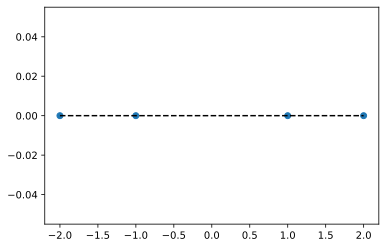

The corresponding problem Hamiltonian is:
H = 2.0ZZII + -2.0ZIZI + -4.0ZIIZ + -1.0IZZI + -2.0IZIZ + 2.0IIZZ 


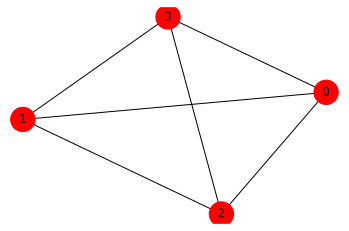

In [2]:
coreset = [(1, np.array([-2,0])), (1, np.array([-1,0])), (1, np.array([1,0])), (1, np.array([2,0]))]
#coreset = None
coreset_points, G, H = kq.gen_coreset_graph(coreset=coreset, metric='dot')
kq.plot_coreset_graph(coreset_points, G)
hstr = ''
for term in H:
    hstr += '{:.1f}{} + '.format(term[0], ''.join(term[1]))
hstr = hstr[:-2]
print('The corresponding problem Hamiltonian is:\nH = {}'.format(hstr))

OrderedDict([('cx', 12), ('rz', 6), ('h', 4), ('rx', 4), ('measure', 4), ('barrier', 3)])


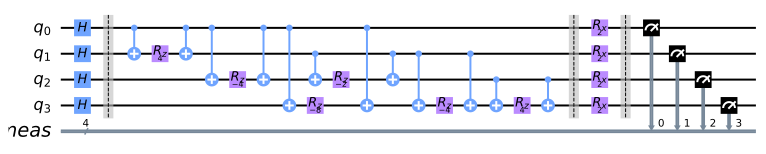

In [3]:
mycirc = kq.gen_complete_qaoa_circ(1, [1], [1], G)
print(mycirc.count_ops())
mycirc.draw(output='mpl', scale=0.4, fold=180)

OrderedDict([('u1', 12), ('cu1', 6), ('h', 4), ('rx', 4), ('measure', 4), ('barrier', 3)])


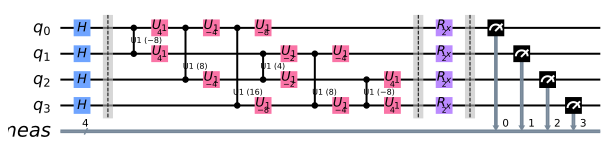

In [4]:
mycirc = kq.gen_complete_qaoa_circ(1, [1], [1], G, ising=True)
print(mycirc.count_ops())
mycirc.draw(output='mpl', scale=0.4, fold=180)

# Run QAOA on QASM simulator

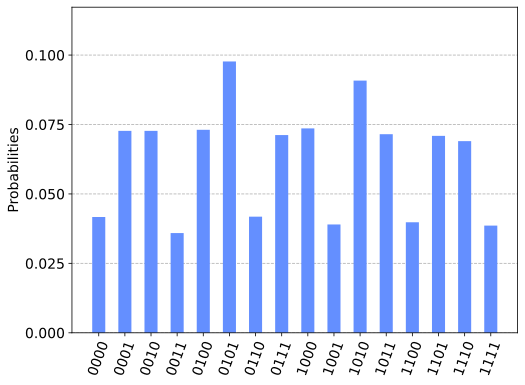

In [5]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")
shots = 10000

simulate = execute(mycirc, backend=backend, shots=shots)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The approximate solution is x* = 0011 with C(x*) = 13 

The cost function is distributed as: 



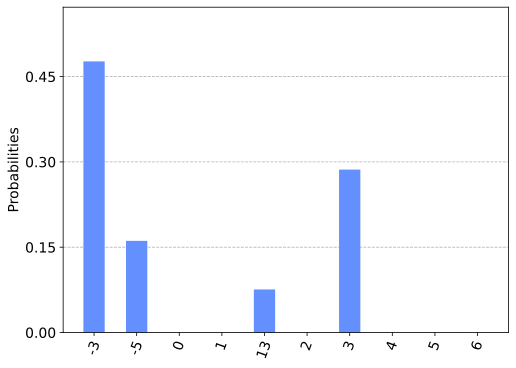

In [6]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C = 0
max_C = [0,0]
hist  = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x = [int(num) for num in list(sample)]
    tmp_eng = kq.cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C = avr_C + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if(max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
#print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

# Energy Landscape

In [16]:
rome.configuration().to_dict()['max_experiments']

75

In [7]:
P = 1
step_size = 0.05
shots = 10000
gammaLim = [0,np.pi]
betaLim = [0,np.pi]
estC, bitstrings = kq.energy_landscape(P, step_size, shots, gammaLim, betaLim, G)

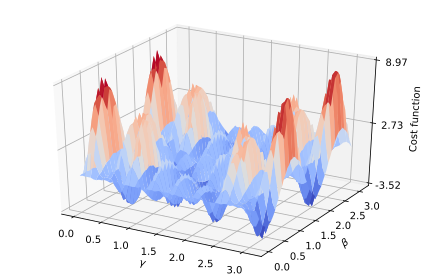


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value (avg over 10000 shots) is:  C = 8.972
This is attained for gamma = 0.550 and beta = 0.150
The 4 most common partitionings produced at this point were:
1011: 8.84%, 0010: 8.60%, 1101: 8.45%, 0100: 8.33%
mu_plus: [0.33333333 0.        ]
mu_minus: [-1.  0.]


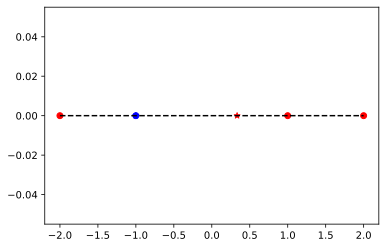

In [8]:
kq.plot_energy_landscape(step_size, gammaLim, betaLim, estC, bitstrings, shots, coreset_points)

# Map to device

In [3]:
provider = IBMQ.load_account()

In [7]:
backends = provider.backends()
for b in backends: print(b)

ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_vigo
ibmq_ourense
ibmq_london
ibmq_burlington
ibmq_essex
ibmq_armonk
ibmq_rome


In [8]:
for backend in backends:
    print(backend.name())
    config = backend.configuration()
    #print(backend.status())
    print(config.n_qubits, config.simulator, config.open_pulse, config.memory)
    #print(config.coupling_map)
    cmap = nx.Graph()
    if config.coupling_map is not None:
        cmap.add_edges_from(config.coupling_map)
        #nx.draw(cmap)
        #plt.show()

ibmq_qasm_simulator
32 True False True
ibmqx2
5 False False True
ibmq_16_melbourne
15 False False True
ibmq_vigo
5 False False True
ibmq_ourense
5 False False True
ibmq_london
5 False False True
ibmq_burlington
5 False False True
ibmq_essex
5 False False True
ibmq_armonk
1 False True True
ibmq_rome
5 False False True


## IBMQ Rome

In [4]:
rome = provider.get_backend('ibmq_rome')
qasm_simulator = provider.get_backend('ibmq_qasm_simulator')
plot_gate_map(rome)
print(type(rome))

<class 'qiskit.providers.ibmq.ibmqbackend.IBMQBackend'>


In [7]:
from qiskit.providers.ibmq.ibmqbackend import IBMQBackend
assert isinstance(rome, IBMQBackend), 'nope!'

### Compile the cnot circuit to Rome

Depth: 18
Gates: OrderedDict([('cx', 17), ('rz', 6), ('h', 4), ('rx', 4), ('measure', 4), ('barrier', 3)])
initial_layout = [0 1 2 3]


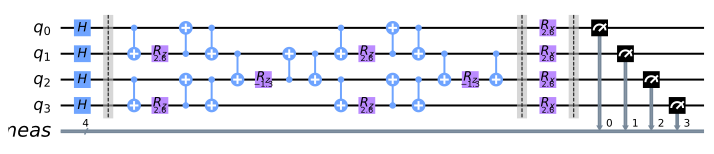

In [8]:
P, gamma, beta = 1, 0.65, 1.3
cnot_circ, initial_layout = kq.gen_complete_qaoa_circ(P, [gamma], [beta], G, ising=False, topology=rome.configuration().coupling_map)
print('Depth:', cnot_circ.depth())
print('Gates:', cnot_circ.count_ops())
print('initial_layout =', initial_layout)
cnot_circ.draw(output='mpl', fold=200, scale=0.4)

               ┌──────────┐ ░                 ┌───┐                                                ┌───┐                            ░ ┌────────────────────┐ ░ ┌─┐         
      q_0 -> 0 ┤ U2(0,pi) ├─░───■─────────────┤ X ├──■───────────────────────────────■─────────────┤ X ├──■─────────────────────────░─┤ U3(2.6,-pi/2,pi/2) ├─░─┤M├─────────
               ├──────────┤ ░ ┌─┴─┐┌─────────┐└─┬─┘┌─┴─┐                 ┌───┐     ┌─┴─┐┌─────────┐└─┬─┘┌─┴─┐                       ░ ├────────────────────┤ ░ └╥┘┌─┐      
      q_1 -> 1 ┤ U2(0,pi) ├─░─┤ X ├┤ U1(2.6) ├──■──┤ X ├──■──────────────┤ X ├──■──┤ X ├┤ U1(2.6) ├──■──┤ X ├──■────────────────■───░─┤ U3(2.6,-pi/2,pi/2) ├─░──╫─┤M├──────
               ├──────────┤ ░ └───┘└─────────┘┌───┐└───┘┌─┴─┐┌──────────┐└─┬─┘┌─┴─┐└───┘└─────────┘┌───┐└───┘┌─┴─┐┌──────────┐┌─┴─┐ ░ ├────────────────────┤ ░  ║ └╥┘┌─┐   
      q_2 -> 2 ┤ U2(0,pi) ├─░───■─────────────┤ X ├──■──┤ X ├┤ U1(-1.3) ├──■──┤ X ├──■─────────────┤ X ├──■──┤ X ├┤ U1(-1.3) ├┤ X ├─░─┤ U3(2

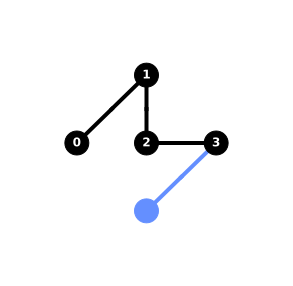

In [9]:
rome_cnots = transpile(cnot_circ, rome, optimization_level=3, initial_layout=initial_layout)
print(rome_cnots.draw(output='text', fold=200))
print('Depth:', rome_cnots.depth())
print('Gates:', rome_cnots.count_ops())
plot_circuit_layout(rome_cnots, rome)

# Run on device

## Simulator

In [16]:
# simulator
shots = 8192
noise_model = noise.device.basic_device_noise_model(rome.properties())
basis_gates = rome.configuration().basis_gates
rome_result = execute(rome_cnots, qasm_simulator, basis_gates=basis_gates, shots=shots, noise_model=noise_model,
                      coupling_map=rome.configuration().coupling_map, backend_properties=rome.properties()).result()
exact_results = execute(rome_cnots, qasm_simulator, shots=shots).result()

/Users/teague/ResearchWorkspace/coresets/coresetEnv/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


mu_plus: [0. 0.]
mu_minus: [0. 0.]


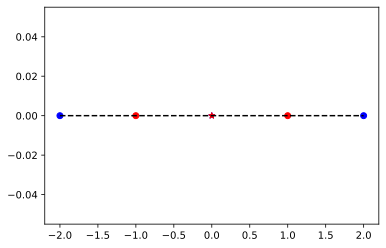

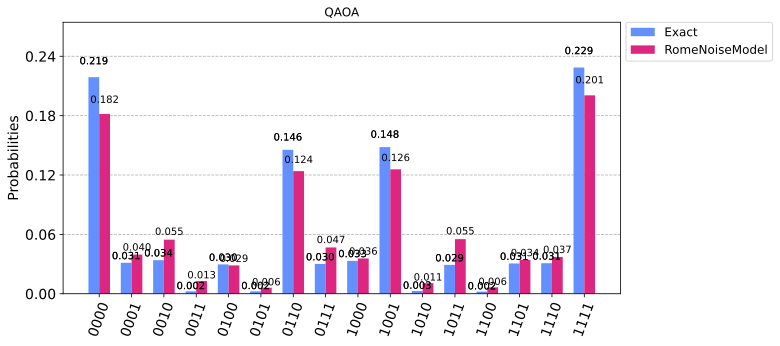

In [17]:
rome_counts = rome_result.get_counts(rome_cnots)
exact_counts = exact_results.get_counts(rome_cnots)

kq.plot_partition('1001', coreset_points)
plot_histogram([exact_counts, rome_counts], figsize=(10,5), legend=['Exact', 'RomeNoiseModel'], title='QAOA')

In [18]:
# generate an energy landscape using noisy simulation
P = 1
step_size = 0.05
shots = 8192
gammaLim = [0,np.pi]
betaLim = [0,np.pi]
estC, bitstrings = kq.energy_landscape(P, step_size, shots, gammaLim, betaLim, G,
                                       device_topology=rome.configuration().coupling_map,
                                       device=rome)

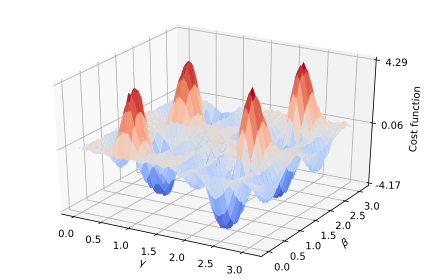


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value (avg over 8192 shots) is:  C = 4.285
This is attained for gamma = 1.200 and beta = 2.350
The 4 most common partitionings produced at this point were:
1001: 7.96%, 0110: 7.78%, 0101: 7.21%, 1101: 7.04%
mu_plus: [0. 0.]
mu_minus: [0. 0.]


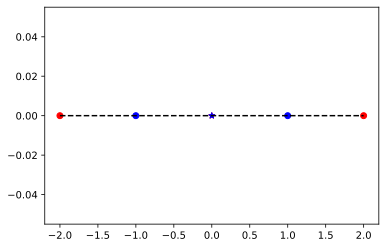

In [19]:
kq.plot_energy_landscape(step_size, gammaLim, betaLim, estC, bitstrings, shots, coreset_points)

## Hardware Execution

In [10]:
print(rome.name())
d = datetime.datetime.today()
print(d.strftime('%m-%d-%Y-%H%M'))

ibmq_rome
04-27-2020-1928


In [29]:
shots = 8192
P = 1
gammas = [0.4, 0.5]
betas = [0.8, 0.7]
circs = []
for gamma, beta in zip(gammas, betas):
    circuit, initial_layout = kq.gen_complete_qaoa_circ(P, [gamma], [beta], G, ising=False, topology=rome.configuration().coupling_map)
    circs.append(circuit)
rome_job1 = execute(circs, backend=rome, shots=shots, initial_layout=initial_layout)
job_monitor(rome_job1)

Job Status: job has successfully run


In [30]:
print(type(rome_job1))
print(rome_job1.result().get_counts())

<class 'qiskit.providers.ibmq.job.ibmqjob.IBMQJob'>
[{'0100': 468, '0110': 494, '1010': 510, '1100': 579, '1111': 384, '1001': 506, '0011': 485, '0000': 789, '1000': 372, '0111': 633, '1101': 447, '1011': 582, '0101': 504, '0001': 390, '0010': 562, '1110': 487}, {'0100': 522, '0110': 303, '1010': 320, '1100': 440, '1111': 353, '1001': 269, '0011': 448, '0000': 1247, '1000': 427, '0111': 623, '1101': 641, '1011': 645, '0101': 315, '0001': 403, '0010': 561, '1110': 675}]


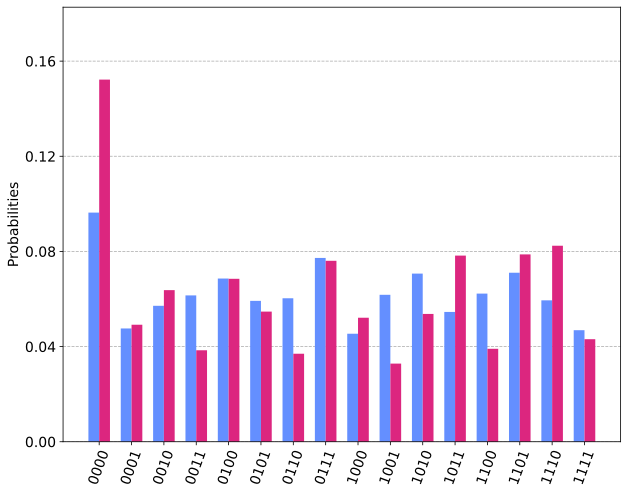

In [32]:
counts1 = kq.reorder_bitstrings(P, len(G.nodes), rome_job1.result().get_counts()[0])
counts2 = kq.reorder_bitstrings(P, len(G.nodes), rome_job1.result().get_counts()[1])
plot_histogram([counts1, counts2],figsize = (10,8),bar_labels = False)

## Energy Landscape

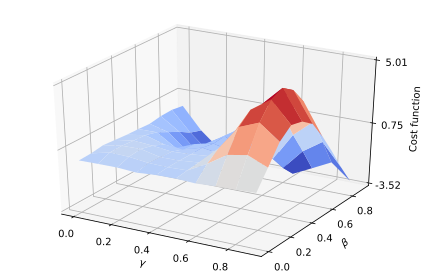


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value (avg over 8192 shots) is:  C = 5.012
This is attained for gamma = 0.400 and beta = 0.800
The 4 most common partitionings produced at this point were:
1111: 7.60%, 0000: 7.54%, 1100: 6.88%, 0011: 6.82%
mu_plus: [0. 0.]
mu_minus: nan


/Users/teague/ResearchWorkspace/coresets/kmeans_qaoa.py:462: RuntimeWarning: invalid value encountered in double_scalars
  mu_minus = np.sum([point[0]*point[1] for point in S_minus], axis=0) / np.sum([point[0] for point in S_minus])


IndexError: invalid index to scalar variable.

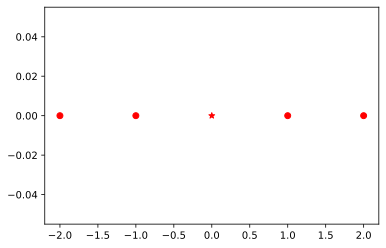

In [4]:
fullrun = kq.load_fullrun('HardwareRunPickles/ibmq_rome_04-27-2020-1929_fullrun.pickle')
gammaLim = [0,1]
betaLim = [0,1]
stepsize = 0.1
shots = 8192
estC = kq.compute_C_from_fullrun(fullrun, gammaLim, betaLim, stepsize, G, shots)
kq.plot_energy_landscape(stepsize, gammaLim, betaLim, estC, fullrun, shots,
                      coreset_points)

In [ ]:
P = 1
gammaLim = [0,np.pi]
betaLim  = [0,np.pi]
step_size = 0.1
shots = 8192
execution_dict = kq.hardware_execution(rome, P, gammaLim, betaLim, step_size, G, shots)

Running ibmq_rome_04-27-2020-2115
Generated 1024 circuits to cover gamma:0 -> 3.14, beta:0 -> 3.14
Device ibmq_rome supports 75 experiments per job
Batched all 1024 circuits into 14 total jobs
LAUNCHING JOBS
Executing job 0
Job Status: job is actively running

# IBM Cu1 gate
Test the Ising gate implementation for cost evolution

In [12]:
backend = Aer.get_backend('unitary_simulator')
np.set_printoptions(precision=3)

In [13]:
# The exact operator (e^(-iZZ))
I = np.identity(2)
X = np.array([[0,1],[1,0]], dtype='complex64')
Y = np.array([[0,0-1j],[0+1j,0]], dtype='complex64')
Z = np.array([[1,0],[0,-1]], dtype='complex64')
Pdict = {'I':I, 'X':X, 'Y':Y, 'Z':Z}

Hmatrix = 0
Hamiltonian = [(1,'ZZ')]
for term in Hamiltonian:
    coef, pauli_str = term
    term_matrix = 1
    for P in pauli_str[::-1]:
        term_matrix = np.kron(Pdict[P], term_matrix)
    Hmatrix = Hmatrix + coef * term_matrix
U = linalg.expm((0-1j) * Hmatrix)
Uop = Operator(U)
print(Uop.is_unitary())

exact_circ = QuantumCircuit(2)
exact_circ.append(Uop, [0, 1])
print(exact_circ)
exact_job = execute(exact_circ, backend)
exact_unitary = exact_job.result().get_unitary(exact_circ, decimals=3)
print(exact_unitary)

True
     ┌──────────┐
q_0: ┤0         ├
     │  Unitary │
q_1: ┤1         ├
     └──────────┘
[[0.54-0.841j 0.  +0.j    0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.54+0.841j 0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54+0.841j 0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    0.54-0.841j]]


In [14]:
# Implement the operator with CNOTs
phi = 1
cnot_circ = QuantumCircuit(2)
cnot_circ.cx(0,1)
cnot_circ.rz(2*phi, 1)
cnot_circ.cx(0,1)
print(cnot_circ)
cnot_job = execute(cnot_circ, backend)
cnot_unitary = cnot_job.result().get_unitary(cnot_circ, decimals=3)
print(cnot_unitary)
# The Rz gate matrix is off from the exact Rz rotation by global phase e^(-i phi)
cnot_w_phase = np.exp((0-1j) * phi) * cnot_unitary
print(cnot_w_phase)

                        
q_0: ──■─────────────■──
     ┌─┴─┐┌───────┐┌─┴─┐
q_1: ┤ X ├┤ Rz(2) ├┤ X ├
     └───┘└───────┘└───┘
[[ 1.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.416+0.909j  0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j    -0.416+0.909j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j   ]]
[[0.54-0.841j 0.  +0.j    0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.54+0.841j 0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54+0.841j 0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    0.54-0.841j]]


In [15]:
# Implement the operator with Ising type gates
ising_circ = QuantumCircuit(2)
ising_circ.cu1(-4*phi, 0, 1)
ising_circ.u1(2*phi, 0)
ising_circ.u1(2*phi, 1)
print(ising_circ)
ising_job = execute(ising_circ, backend)
ising_unitary = ising_job.result().get_unitary(ising_circ, decimals=3)
print(ising_unitary)
# The Rz gate matrix is off from the exact Rz rotation by global phase e^(-i phi)
ising_w_phase = np.exp((0-1j) * phi) * ising_unitary
print(ising_w_phase)

          ┌───────┐
q_0: ─■───┤ U1(2) ├
      │-4 ├───────┤
q_1: ─■───┤ U1(2) ├
          └───────┘
[[ 1.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.416+0.909j  0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j    -0.416+0.909j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j   ]]
[[0.54-0.841j 0.  +0.j    0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.54+0.841j 0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54+0.841j 0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    0.54-0.841j]]
